## California House Price Prediction using XGBOOST
- XGBoost: is a machine learning algorithm based on decision trees (built sequentially).
- Each new decision tree (weak learner) is explicitly designed to correct the errors (residuals) made by all the previously built trees in the sequence.
- handles non-linearity.
- can do regression or classification.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

## STEP 1: Extract the data from sklearn.datasets and put it on a pandas dataframe

In [11]:
house_price_dataset = sklearn.datasets.fetch_california_housing()
print(house_price_dataset)

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
          37.88      , -122.23      ],
       [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
          37.86      , -122.22      ],
       [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
          37.85      , -122.24      ],
       ...,
       [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
          39.43      , -121.22      ],
       [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
          39.43      , -121.32      ],
       [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
          39.37      , -121.24      ]]), 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]), 'frame': None, 'target_names': ['MedHouseVal'], 'feature_names': ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'], 'DESCR': '.. _california_housing_dataset:\n\nCalifornia Housing dataset\n-

In [8]:
df = pd.DataFrame(house_price_dataset.data, columns = house_price_dataset.feature_names)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [14]:
df["price"] = house_price_dataset.target
df.head()

# Units are hundreds of thousands of dollars: 4.526 → $452,600

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## STEP 2: EDA

In [16]:
#check the number of rows and columns on the dataset
df.shape

(20640, 9)

In [17]:
#check for missing/null values
df.isnull().sum()

,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
price,0


In [19]:
#statisctical metrics from the dataset
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [45]:
# concise summary of a DataFrame's structure and contents
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   price       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


## STEP 3: Understand the correlations between various features on the dataset

<Axes: >

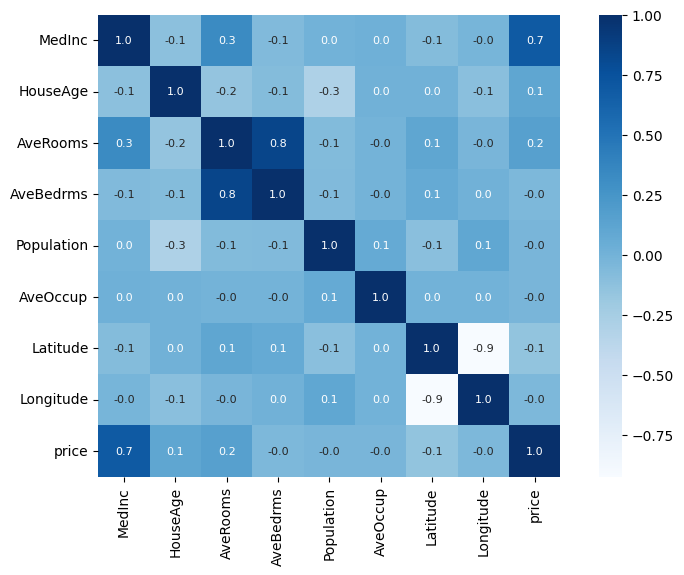

In [21]:
correlation = df.corr()

#Correlation map
plt.figure(figsize=(10,6))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

#correlation relationship is always linear

 - The correlation matrix shows that median income has the strongest linear relationship with housing prices (≈0.7), indicating income is the primary driver of house values. Room-related features are highly correlated with each other, suggesting redundancy. Geographic variables exhibit weak linear correlations with price but are strongly correlated with each other, implying location effects are non-linear. This supports the use of tree-based models such as XGBoost, which can capture complex interactions beyond linear relationships.

## STEP 4: XGBoost Regressor

### Determine X and y

In [24]:
X = df[["MedInc","HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "Latitude","Longitude"]]
y = df["price"]

### Train Test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

### Model

In [26]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

### In-sample performance (prediction on training data)

In [28]:
t_pred = model.predict(X_train)

In [35]:
# R Squared Error
score_1 = metrics.r2_score(y_train, t_pred)

# Mean Absolute Error
score_2 = metrics.mean_absolute_error(y_train, t_pred)

print('R Squared Error:', score_1)
print('Mean Absolute Error:', score_2)

R Squared Error: 0.943650140819218
Mean Absolute Error: 0.1933648700612105


### Out-of-Sample  (prediction on test data)

In [32]:
y_pred = model.predict(X_test)

In [34]:
# R Squared Error
score_1 = metrics.r2_score(y_test, y_pred)

# Mean Absolute Error
score_2 = metrics.mean_absolute_error(y_test, y_pred)

print('R Squared Error:', score_1)
print('Mean Absolute Error:', score_2)

R Squared Error: 0.8338000331788725
Mean Absolute Error: 0.3108631800268186


### Plot Actual vs Predicted House Prices on the test set

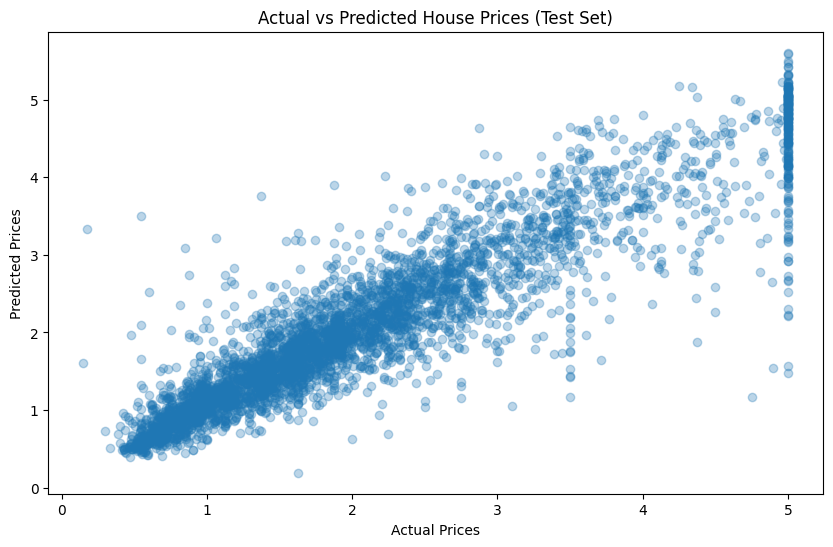

In [38]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred, alpha=0.3)

plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices (Test Set)")

plt.show()

 - Most points form a tight upward diagonal.
 - When actual prices increase, predicted prices also increase.
 - The model captures the overall structure of the data.
- This visually matches your high test R² (0.83).